In [2]:
from collections import namedtuple

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

import pytorch_lightning as pl

import tqdm
import json
import sklearn.metrics as sm

from torch.utils.data import Dataset, DataLoader, TensorDataset
import tensorboardX as tb
import tensorflow as tf
import datetime, os

import matplotlib.pyplot as plt
import seaborn as sns

SEED = 777
import random

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

2023-04-11 17:30:15.458522: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
DIR = './data/'

In [4]:
# load generated data with process
data = pd.read_json(DIR + 'input.json', lines=True)
# load top tracks data
top_tracks = pd.read_json(DIR + "top_tracks.json", lines=True).iloc[0].to_list()
# load tracks
tracks = pd.read_json(DIR + "tracks.json", lines=True)
# load user-based recommendations
ub = pd.read_json(DIR + "recommendations_ub.json", lines=True)

In [49]:
dataset = data[["user", "track", "time"]]

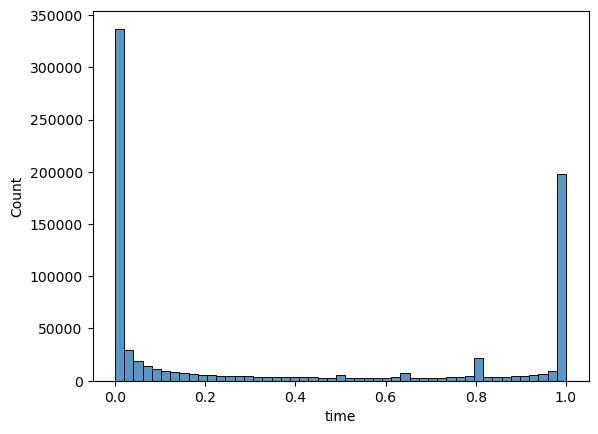

In [50]:
figure, ax = plt.subplots()
sns.histplot(dataset["time"], ax=ax)
pass

In [51]:
# split data to train/val/test
rdm = np.random.random(len(dataset))
train_data = dataset[rdm < 0.8].reset_index(drop=True)
val_data = dataset[(rdm >= 0.8) & (rdm < 0.9)].reset_index(drop=True)
test_data = dataset[rdm >= 0.9].reset_index(drop=True)

len(train_data), len(val_data), len(test_data)

(652131, 81307, 81817)

In [53]:
users_set = set(dataset['user'].to_list())
tracks_set = set(dataset['track'].to_list())

In [54]:
NUM_USERS = data['user'].nunique()
NUM_TRACKS = data['track'].nunique()

In [55]:
class CustomRecommenderDataset(pl.LightningDataModule):

    def __init__(self, train_data, val_data, test_data, features):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.features = features

    def prepare_data(self):
        self.test_data = self.test_data.assign(rdm = np.random.random(len(self.test_data))).assign(avg = self.train_data["time"].mean())

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_dataset = TensorDataset(
              torch.from_numpy(self.train_data[self.features].values), 
              torch.from_numpy(self.train_data["time"].values)
              )

            self.val_dataset = TensorDataset(
            torch.from_numpy(self.val_data[self.features].values), 
            torch.from_numpy(self.val_data["time"].values)
            )
        
        if stage == "test" or stage is None:  
            self.test_dataset = TensorDataset(
            torch.from_numpy(self.test_data[self.features].values),
            torch.from_numpy(self.test_data[["time", "avg", "rdm"]].values)
        )
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=2048, shuffle=True, num_workers=0)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=2048, num_workers=0)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=512, shuffle=False, num_workers=0)

In [56]:
class CustomRecommender(pl.LightningModule):
    def __init__(self, embedding_dim=64):
        super().__init__()
        self.embedding_dim = embedding_dim
        
        self.user_emb = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)
        self.track_emb = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)
        
        self.output = nn.Linear(in_features=2 * self.embedding_dim, out_features=1)
        self.relu = nn.ReLU()
        
    def forward(self, user_input, track_input):
        user_embedded = self.user_emb(user_input)
        track_embedded = self.track_emb(track_input)
        vector = torch.cat([user_embedded, track_embedded], dim=-1)
        vector = self.relu(vector)
        
        return self.output(vector)
        
    def step(self, batch, batch_idx, metric, prog_bar=False):
        x, y = batch
        user_input, track_input = x[:, 0], x[:, 1]
        label = y
        
        predictions = self.forward(user_input, track_input)
        
        loss = F.mse_loss(predictions, label.unsqueeze(1).float(), reduction='mean')
        self.log(metric, loss, prog_bar=prog_bar)
       
        return loss
    
    def test_step(self, batch, batch_idx, prog_bar=False):
        x, y = batch
        
        user_input, track_input = x[:, 0], x[:, 1]
        label = y
        predictions = self.forward(user_input, track_input)
        targets = label[:, 0].float()
        avgs = label[:, 1].float()
        rdms = label[:, 2].float()

        loss = F.mse_loss(predictions, targets, reduction='mean')
        avg_loss = F.mse_loss(avgs, targets, reduction='mean')
        rdm_loss = F.mse_loss(rdms, targets, reduction='mean')

        self.log("test_loss", loss, prog_bar=prog_bar)
        self.log("avg_loss", avg_loss, prog_bar=prog_bar)
        self.log("rdm_loss", rdm_loss, prog_bar=prog_bar)

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train_loss")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val_loss", True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'reduce_on_plateau': True,
            'monitor': 'val_loss'
        }
        
        return [optimizer], [scheduler]

In [57]:
net = CustomRecommender(embedding_dim=128)
data_module = CustomRecommenderDataset(train_data, val_data, test_data, features = ["user", "track"])

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss")

trainer = pl.Trainer(
    max_epochs=100,
    accelerator='gpu', 
    devices=1,
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=5),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        checkpoint_callback
    ])

In [58]:
trainer.fit(
    net, 
    data_module
)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00036: reducing learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00053: reducing learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [59]:
best = CustomRecommender.load_from_checkpoint(checkpoint_callback.best_model_path, embedding_dim=128)

In [60]:
trainer.test(best, data_module)

Testing: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Using a target size (torch.Size([409])) that is different to the input size (torch.Size([409, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         avg_loss          │    0.1883382797241211     │
│         rdm_loss          │    0.28323328495025635    │
│         test_loss         │    0.22522090375423431    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.22522090375423431,
  'avg_loss': 0.1883382797241211,
  'rdm_loss': 0.28323328495025635}]

### Sum up all predictions data:

In [61]:
results_by_user = {}

In [63]:
from random import choices

for user in tqdm.tqdm(users_set):
    if user not in ub.keys():
        tracks = choices(top_tracks[:10000], k=500)
    else:
        tracks = ub[user]
    for track in tracks:
        result = net(torch.LongTensor([user]), torch.LongTensor([track]))
        if result.item() > 0.8:
            if user not in results_by_user:
                results_by_user[user] = [track]
            else:
                results_by_user[user].append(track)

100%|██████████| 10000/10000 [06:08<00:00, 27.17it/s]


### Сохраняем все в botify

In [64]:
k = 100
with open("../botify/data/custom_recommendations.json", "w") as rf:
    for value, key in tqdm.tqdm(results_by_user.items()):
        recommendation = {'user': value, 'recommendations': key[:100]}
        
        rf.write(json.dumps(recommendation) + "\n")

100%|██████████| 9998/9998 [00:00<00:00, 58678.01it/s]
